In [10]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [12]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import cv2

In [14]:
import os
for dirname, _, filenames in os.walk('/images'):
    for filename in filenames:                    #traverse through the directory '/images' and its subdirectories,
        print(os.path.join(dirname, filename))    #printing the full path of each file encountered.


In [15]:
tf.random.set_seed(23)

In [16]:
data_dir = 'images'
print(os.listdir(data_dir))
classes_train = os.listdir(data_dir + "/train") #This line creates a list called classes_train and populates it with the names of the directories (representing classes) found within the images/train subdirectory.
classes_valid = os.listdir(data_dir + "/validation")
print(f'Train Classes - {classes_train}')
print(f'Validation Classes - {classes_valid}')

['.DS_Store', 'train', 'validation']
Train Classes - ['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']
Validation Classes - ['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']


In [17]:
# Creating the Pathlib PATH objects
train_path = Path("/images/train")
valid_path = Path("/images/validation")

In [19]:
train_dataset_main = data_dir + "/train"        # these more but same paths i made as create_dataset function below wasn't working 
valid_dataset_main = data_dir + "/validation"  # properly with train_path and valid_path

In [20]:
def create_dataset_df(main_path, dataset_name):
    print(f"{dataset_name} is being created ...")
    df = {"img_path":[],"class_names":[]}
    for class_names in os.listdir(main_path):
            for img_path in glob.glob(f"{main_path}/{class_names}/*"):
                df["img_path"].append(img_path)
                df["class_names"].append(class_names)
    df = pd.DataFrame(df)
    print(f"{dataset_name} has been created!")
    return df

In [21]:
train_df = create_dataset_df(train_dataset_main, "Train dataset")

Train dataset is being created ...
Train dataset has been created!


In [22]:
valid_df=create_dataset_df(valid_dataset_main, "Validation dataset")

Validation dataset is being created ...
Validation dataset has been created!


In [23]:


train_df.sample(5)



,img_path,class_names
654,images/train/happy/15460.jpg,happy
20829,images/train/neutral/31776.jpg,neutral
449,images/train/happy/34282.jpg,happy
13950,images/train/fear/16093.jpg,fear
17749,images/train/surprise/30243.jpg,surprise


In [24]:
valid_df.sample(5)

,img_path,class_names
2372,images/validation/sad/18732.jpg,sad
418,images/validation/happy/22750.jpg,happy
1688,images/validation/happy/26676.jpg,happy
3409,images/validation/fear/460.jpg,fear
140,images/validation/happy/21538.jpg,happy


In [25]:
print(f"training samples: {len(train_df)} \nvalidation samples: {len(valid_df)}")

training samples: 28821 
validation samples: 7066


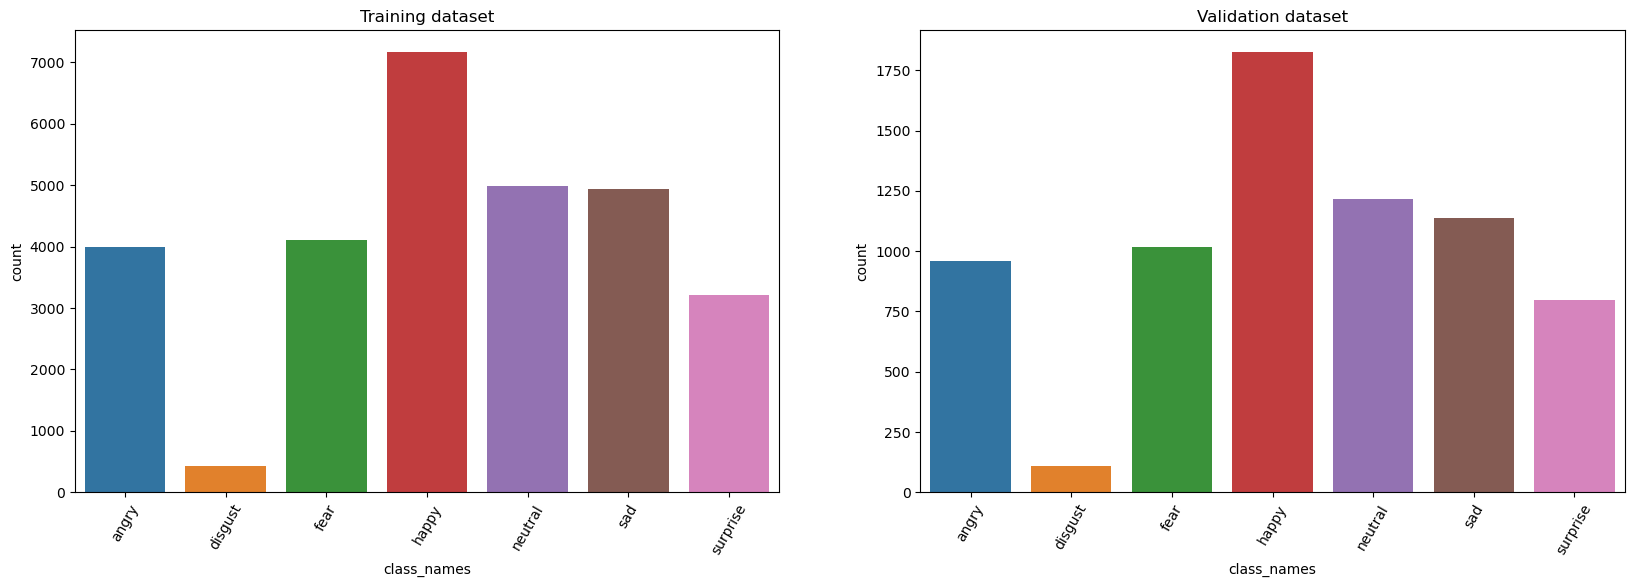

In [28]:


plt.figure(figsize=(20,6))
# train dataset
plt.subplot(1,2,1)
sns.countplot(data=train_df.sort_values("class_names"),x="class_names")
plt.title("Training dataset")
plt.xticks(rotation = 60)
# validation dataset
plt.subplot(1,2,2)
sns.countplot(data=valid_df.sort_values("class_names"),x="class_names")
plt.title("Validation dataset")
plt.xticks(rotation = 60)

plt.show()



In [29]:


from sklearn.preprocessing import LabelEncoder 

Le = LabelEncoder()
train_df["class_names"] = Le.fit_transform(train_df["class_names"])

train_df["class_names"].value_counts()



3    7164
4    4982
5    4938
2    4103
0    3993
6    3205
1     436
Name: class_names, dtype: int64

In [30]:
valid_df["class_names"] = Le.transform(valid_df["class_names"])



In [31]:
valid_df["class_names"].value_counts()

3    1825
4    1216
5    1139
2    1018
0     960
6     797
1     111
Name: class_names, dtype: int64

# One Hot Encoding

In [32]:

train_labels = tf.keras.utils.to_categorical(train_df["class_names"])
valid_labels = tf.keras.utils.to_categorical(valid_df["class_names"])



In [33]:
train_labels[:10]

array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

# Calculating Class Weights

In [34]:


# Compute class weights 

classTotals = train_labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

class_weight = {e : weight for e , weight in enumerate(classWeight)}
print(class_weight)



{0: 1.7941397, 1: 16.431192, 2: 1.7460395, 3: 1.0, 4: 1.4379767, 5: 1.4507898, 6: 2.2352574}


In [35]:
input_image = cv2.imread(train_df.img_path[0])

input_image.shape

(48, 48, 3)

In [36]:
# Function used for Transformation

def load(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    return image , label

In [37]:


# Define IMAGE SIZE and BATCH SIZE 
IMG_SIZE = 96 
BATCH_SIZE = 64

# Basic Transformation
resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE)          
])

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (-0.1, -0.05))
])



In [38]:
AUTOTUNE = tf.data.experimental.AUTOTUNE #to find a good allocation of CPU budget across all parameters

def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset))

    dataset = dataset.map(lambda image , label : load(image , label))
    dataset = dataset.map(lambda image, label: (resize(image), label) , num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)

    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label) , num_parallel_calls=AUTOTUNE)
        dataset = dataset.repeat()
    
    return dataset

In [39]:
# Creating Train Dataset object and Verifying it

train_dataset = get_dataset(train_df["img_path"], train_labels)

#iter() returns an iterator of the given object
#next() returns the next number in an iterator
image , label = next(iter(train_dataset)) 
print(image.shape)
print(label.shape)

(64, 96, 96, 3)
(64, 7)


happy


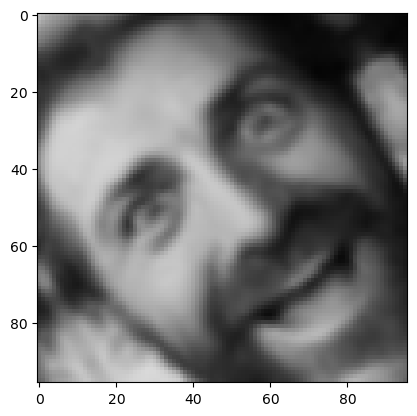

In [40]:
# View a sample Training Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [41]:
val_dataset = get_dataset(valid_df["img_path"] , valid_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)


(64, 96, 96, 3)
(64, 7)


happy


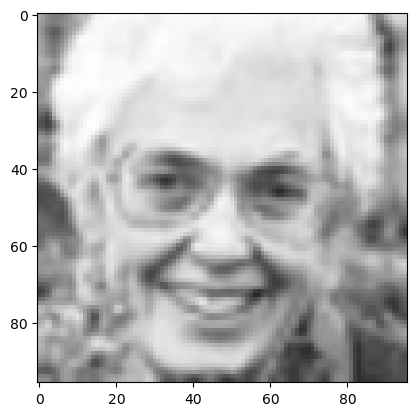

In [42]:
 #View a sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))



In [43]:
#Building EfficientNet model
# from tensorflow.keras.applications import EfficientNetB2

# backbone = EfficientNetB2(
#     input_shape=(96, 96, 3),
#     include_top=False
# )

# model = tf.keras.Sequential([
#     backbone,
#     tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(7, activation='softmax')
# ])

# model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional  (None, 3, 3, 1408)        7768569   
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 3, 3, 128)         1622144   
                                                                 
 global_average_pooling2d (  (None, 128)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                

In [44]:
# Compiling your model by providing the Optimizer , Loss and Metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)


In [45]:
len(train_labels),len(valid_labels)

(28821, 7066)

In [46]:
#early_stopping=tf.keras.callbacks.EarlyStopping(monitor="accuracy",patience=2,mode="auto")

In [48]:
# Train the model
# history = model.fit(
#     train_dataset,
#     steps_per_epoch=len(train_labels)//BATCH_SIZE,
#     epochs=8,
#     validation_data=val_dataset,
#     validation_steps = len(valid_labels)//BATCH_SIZE,
#     class_weight=class_weight
# )


Epoch 1/8
450/450 [==============================] - 1289s 3s/step - loss: 1.1379 - accuracy: 0.8566 - precision: 0.8769 - recall: 0.8330 - val_loss: 73.3131 - val_accuracy: 0.1273 - val_precision: 0.1273 - val_recall: 0.1273
Epoch 2/8
450/450 [==============================] - 1217s 3s/step - loss: 1.1433 - accuracy: 0.8440 - precision: 0.8788 - recall: 0.8030 - val_loss: 9.3603 - val_accuracy: 0.0908 - val_precision: 0.1077 - val_recall: 0.0649
Epoch 3/8
450/450 [==============================] - 1221s 3s/step - loss: 1.2253 - accuracy: 0.8381 - precision: 0.8778 - recall: 0.7937 - val_loss: 6.4462 - val_accuracy: 0.0155 - val_precision: 0.0156 - val_recall: 0.0141
Epoch 4/8
450/450 [==============================] - 1435s 3s/step - loss: 1.1181 - accuracy: 0.8254 - precision: 0.8587 - recall: 0.7820 - val_loss: 9.3085 - val_accuracy: 0.0155 - val_precision: 0.0155 - val_recall: 0.0155
Epoch 5/8
450/450 [==============================] - 1665s 4s/step - loss: 1.3019 - accuracy: 0.819

In [54]:
import itertools  # Import 'itertools' for iterators and looping
from collections import Counter

111/111 [==============================] - 58s 519ms/step
[[0.18555108 0.23902567 0.1151749  ... 0.16158794 0.07087128 0.14238057]
 [0.17864095 0.23221102 0.11441611 ... 0.16623929 0.0731893  0.14540324]
 [0.18936001 0.2411788  0.11436934 ... 0.16364093 0.06805447 0.14343692]
 ...
 [0.19002119 0.2358076  0.11378663 ... 0.1693481  0.06791669 0.14605188]
 [0.1905623  0.24387757 0.11300561 ... 0.16370103 0.06661134 0.1430229 ]
 [0.19498023 0.23870263 0.11042048 ... 0.17663674 0.06178346 0.14986655]]


In [57]:
evaluation_results = model.evaluate(val_dataset)
print(evaluation_results)

111/111 [==============================] - 60s 537ms/step - loss: 2.1869 - accuracy: 0.0157 - precision: 0.0000e+00 - recall: 0.0000e+00
[2.1868627071380615, 0.015709029510617256, 0.0, 0.0]


In [59]:
# outputs = model.predict(val_dataset)
# print(outputs)


111/111 [==============================] - 61s 550ms/step
[[0.1894647  0.24465975 0.11237123 ... 0.16175501 0.06789614 0.1415285 ]
 [0.18977612 0.24129501 0.11385709 ... 0.1643524  0.06763902 0.14359963]
 [0.18761465 0.23974995 0.11458878 ... 0.16322121 0.069349   0.14313592]
 ...
 [0.18958633 0.24114574 0.11430489 ... 0.16390066 0.06790326 0.14355665]
 [0.19060257 0.23957266 0.11402465 ... 0.16619502 0.0673922  0.14462118]
 [0.19451888 0.24207874 0.11238728 ... 0.16857229 0.06428856 0.1454555 ]]


In [80]:
# model.save("my_model.keras")

In [81]:
from tensorflow.keras.models import load_model

loaded_model = load_model("my_model.keras")

In [88]:
# val_data = np.array(list(val_dataset))
# tensor_data = tf.convert_to_tensor(val_data[1])
# predictions = loaded_model.predict(tensor_data)

In [90]:

# predicted_class = np.argmax(outputs)
# print(predicted_class)

28302


In [98]:
from tensorflow.keras.preprocessing import image

img_path = "images/validation/fear/21.jpg"
img = image.load_img(img_path, target_size=(96, 96))  # Assuming 224x224 input
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Make prediction
predictions = loaded_model.predict(img_batch)
predicted_class = np.argmax(predictions) 
#print(predicted_class)

1/1 [==============================] - 0s 256ms/step


In [99]:
print(predicted_class)

1
